In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


# CREDIT FRAUD

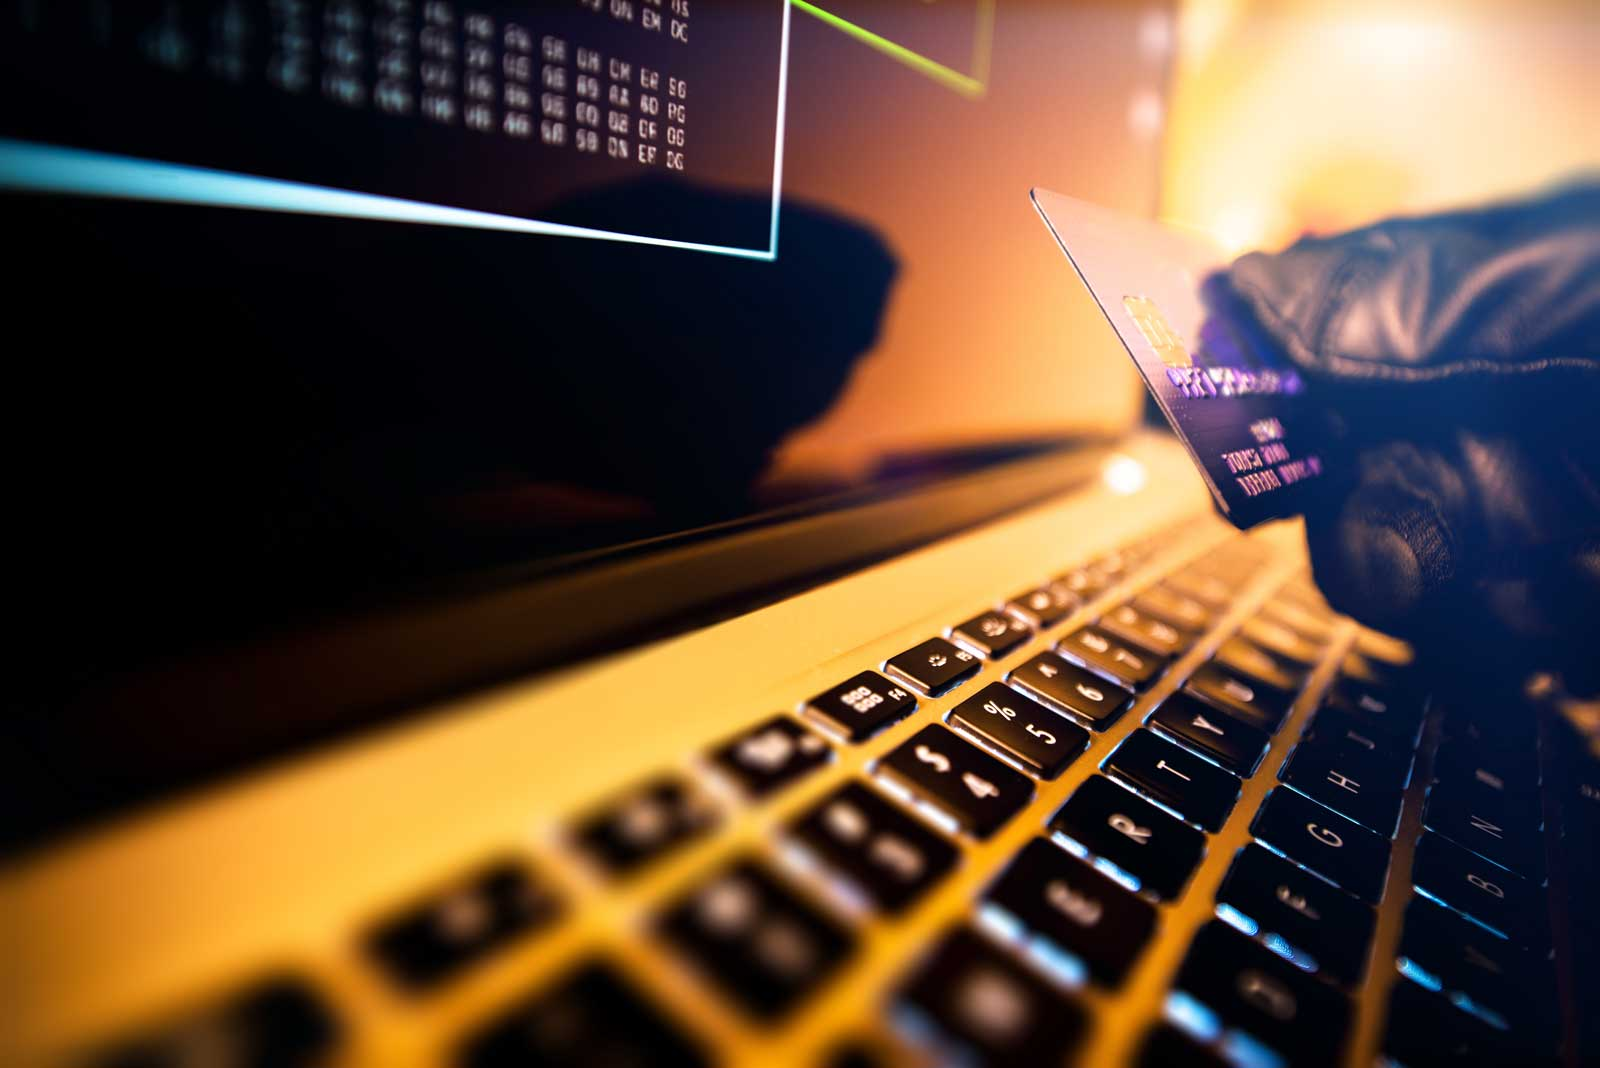

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [3]:
from keras.models import Model, load_model, Sequential
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Bidirectional, GRU, Dense,Dropout
from tensorflow.keras import optimizers
import tensorflow as tf

In [4]:
all_data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [5]:
all_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
all_data.isnull().sum().max()

0

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

all_data['scaled_amount'] = rob_scaler.fit_transform(all_data['Amount'].values.reshape(-1,1))
all_data['scaled_time'] = rob_scaler.fit_transform(all_data['Time'].values.reshape(-1,1))

all_data.drop(['Time','Amount'], axis=1, inplace=True)

In [8]:
scaled_amount = all_data['scaled_amount']
scaled_time = all_data['scaled_time']

all_data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
all_data.insert(0, 'scaled_amount', scaled_amount)
all_data.insert(1, 'scaled_time', scaled_time)

**The goal of the problem is to be able to distinguish between the Target Class (0 or 1)**



0    284315
1       492
Name: Class, dtype: int64


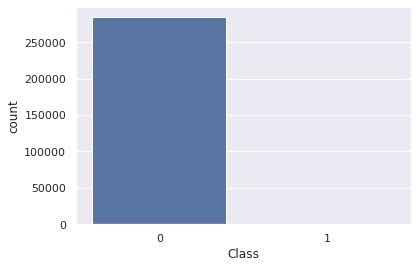

In [9]:
target = 'Class'
ax = sns.countplot(x=target,data=all_data)
print(all_data[target].value_counts())

**There is a large imbalance of data. There are few fraudulent entries. Therefore there is a large imbalance between positive and fraudulent transactions. In order to solve it, I will use the SMOTE technique - Synthetic Minority Oversampling Technique**

# TREATMENT OF THE UNBALANCED DATA SET - Synthetic Minority Oversampling Technique (SMOTE)

In [10]:
#Positive transactions %

percentage_P_Tr = 100*(284315/float(all_data.shape[0]))
percentage_P_Tr

99.82725143693798

In [11]:
#Fraudulent transactions %

percentage_F_Tr = 100*(492/float(all_data.shape[0]))
percentage_F_Tr

0.1727485630620034

**Use Smote to treat the unbalanced dataset and generate an increase in positive cases with fraudulent transactions (Oversampling)**

In [12]:
X = all_data.loc[:,all_data.columns!=target]
y = all_data.loc[:,all_data.columns==target]

In [13]:
import seaborn as sns
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_overSamp, y_overSamp = oversample.fit_resample(X, y)

0    284315
1    284315
Name: Class, dtype: int64


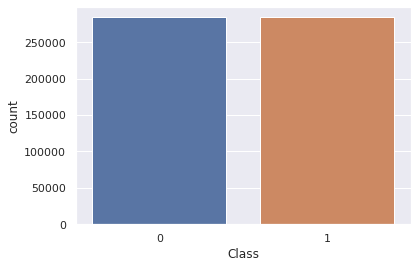

In [14]:
ax = sns.countplot(x=target,data=y_overSamp)
print(y_overSamp[target].value_counts())

**As can be seen in the graph, I have matched the positive and negative cases. The dataset is already balanced**

<AxesSubplot:>

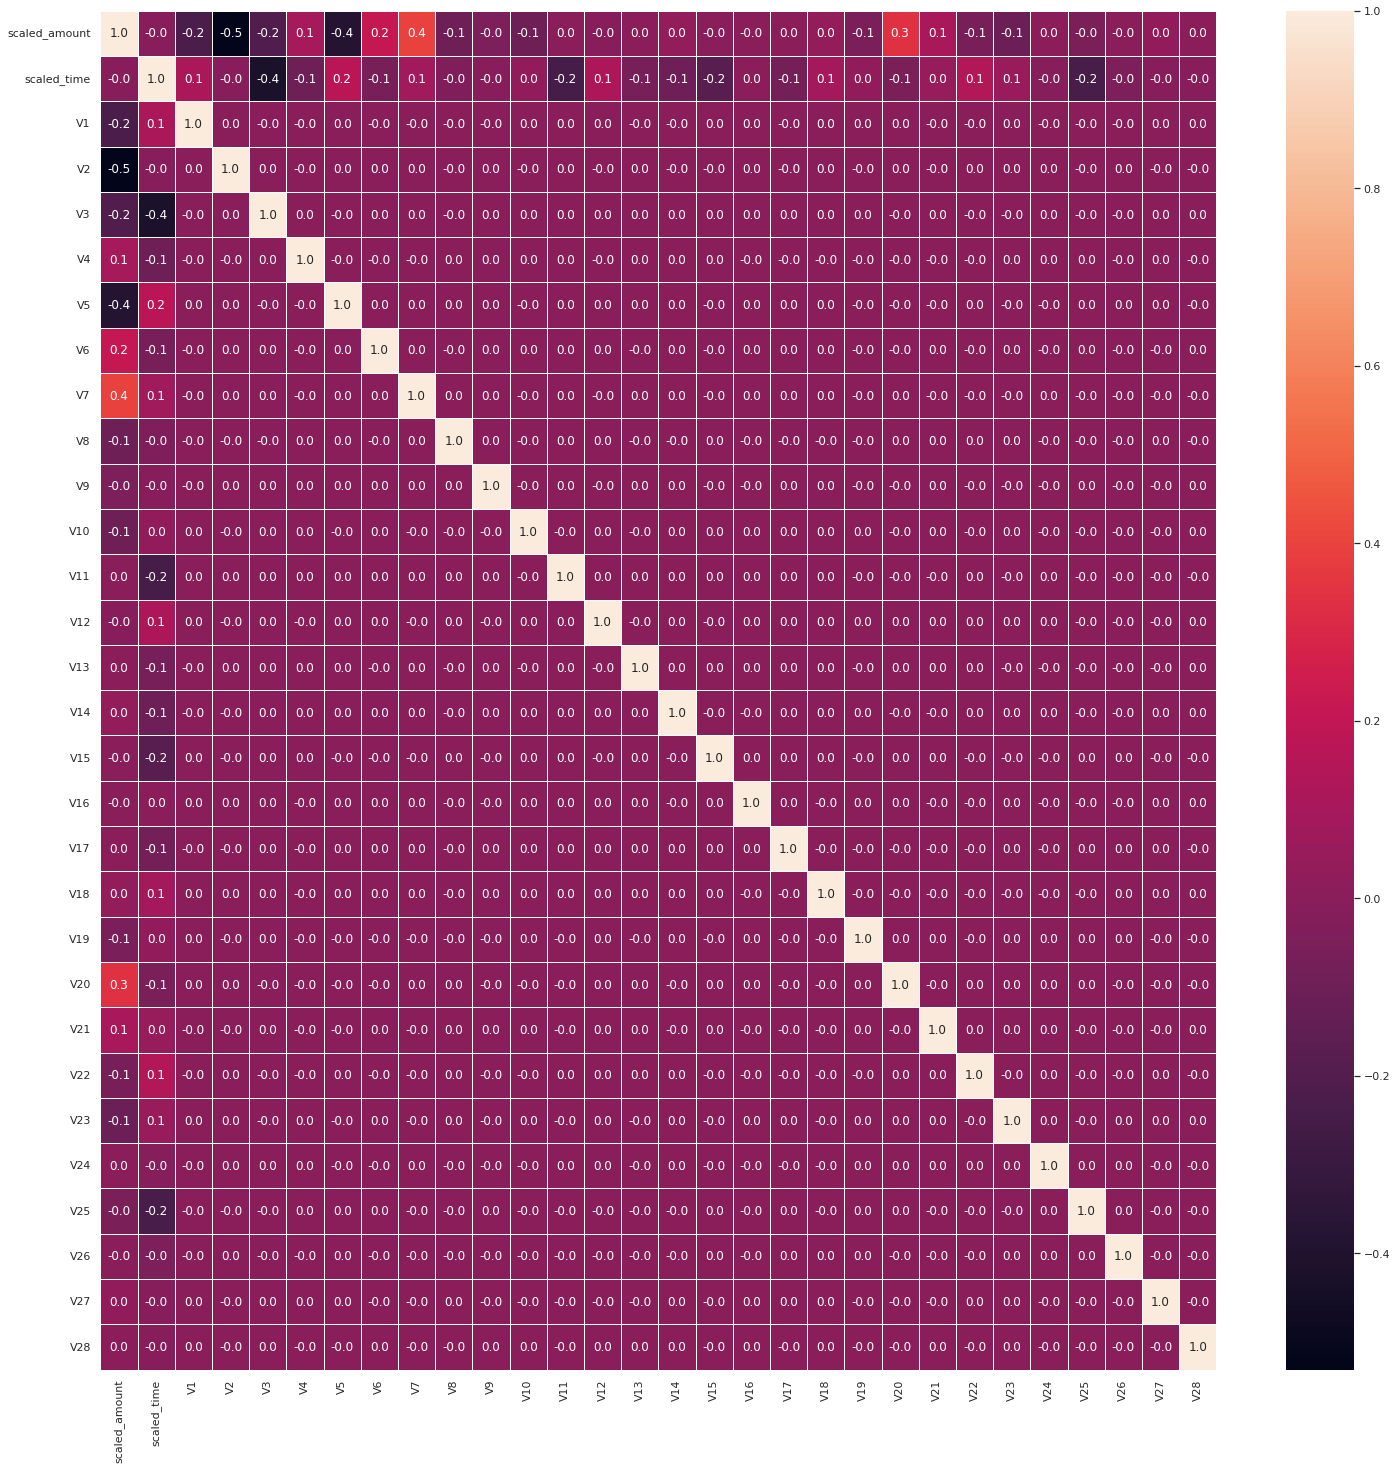

In [15]:
# check correlation
data_num = all_data.drop('Class', axis=1)
corr = data_num.corr()

#correlation map
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(data_num.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True)

In [17]:
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (242085, 30)
x_test shape:  (42722, 30)
y_train shape:  (242085, 1)
y_test shape:  (42722, 1)


In [18]:
#Standardize features 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

# MODEL CREATION
**To reduce the dimensionality of the data I will apply Deep Learning techniques. In this case I am going to make use of Autoecoders to keep the part of the Encoder which compresses and reduces the dimensionality of the data.**

In [19]:
#AUTOENCODER DENSE LAYERS
capa_entrada =  Input(shape=(x_train.shape[1],)) 
encoded_layer_1 = Dense(25, activation='relu',name='encoder_layer_1')(capa_entrada)
encoded_layer_2 = Dense(20, activation='relu',name='encoder_layer_2')(encoded_layer_1)
encoded_layer_3 = Dense(15, activation='relu',name='encoder_layer_3')(encoded_layer_2)

## latent view
latent_view   = Dense(10, activation='tanh',name='latent_layer')(encoded_layer_3)

#Decoded
decoded_layer_1 = Dense(15, activation='relu',name='decoder_layer_1')(latent_view)
decoded_layer_2 = Dense(20, activation='relu',name='decoder_layer_2')(decoded_layer_1)
decoded_layer_3 = Dense(25, activation='relu',name='decoder_layer_3')(decoded_layer_2)

##output layer
output_layer  = Dense(x_train.shape[1],name='output_layer')(decoded_layer_3)

autoencoder_Dense = Model(capa_entrada, output_layer)
encoder_Dense = Model(capa_entrada,latent_view)

2022-09-22 10:36:19.384302: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
#Summary
autoencoder_Dense.summary()
encoder_Dense.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
encoder_layer_1 (Dense)      (None, 25)                775       
_________________________________________________________________
encoder_layer_2 (Dense)      (None, 20)                520       
_________________________________________________________________
encoder_layer_3 (Dense)      (None, 15)                315       
_________________________________________________________________
latent_layer (Dense)         (None, 10)                160       
_________________________________________________________________
decoder_layer_1 (Dense)      (None, 15)                165       
_________________________________________________________________
decoder_layer_2 (Dense)      (None, 20)                320   

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=50)
autoencoder_Dense.compile(optimizer='adam', loss='mse',metrics=['mse','acc'])

In [22]:
history = autoencoder_Dense.fit(x_train,x_train,
                          epochs=30,
                          batch_size=256,
                          validation_data=(x_test, x_test),
                          callbacks=[early_stop])

2022-09-22 10:36:19.816141: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
946/946 [==============================] - 6s 6ms/step - loss: 0.7308 - mse: 0.7308 - acc: 0.2480 - val_loss: 0.6026 - val_mse: 0.6026 - val_acc: 0.3037
Epoch 2/30
946/946 [==============================] - 6s 6ms/step - loss: 0.5499 - mse: 0.5499 - acc: 0.3568 - val_loss: 0.4755 - val_mse: 0.4755 - val_acc: 0.3999
Epoch 3/30
946/946 [==============================] - 5s 6ms/step - loss: 0.4472 - mse: 0.4472 - acc: 0.4337 - val_loss: 0.4106 - val_mse: 0.4106 - val_acc: 0.4603
Epoch 4/30
946/946 [==============================] - 5s 5ms/step - loss: 0.3986 - mse: 0.3986 - acc: 0.4764 - val_loss: 0.3774 - val_mse: 0.3774 - val_acc: 0.4864
Epoch 5/30
946/946 [==============================] - 5s 5ms/step - loss: 0.3774 - mse: 0.3774 - acc: 0.4947 - val_loss: 0.3661 - val_mse: 0.3661 - val_acc: 0.5014
Epoch 6/30
946/946 [==============================] - 5s 6ms/step - loss: 0.3635 - mse: 0.3635 - acc: 0.5069 - val_loss: 0.3540 - val_mse: 0.3540 - val_acc: 0.5132
Epoch 7/30
946/9

In [23]:
X_train = encoder_Dense(x_train)
X_test = encoder_Dense(x_test)

In [24]:
from sklearn.ensemble import RandomForestClassifier

def rf(X_train, y_train, n_estimators=300):
    clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

random_forest_en = rf(X_train,y_train, n_estimators=300) 

In [25]:
print('Train accuracy: ', random_forest_en.score(X_train, y_train))
print('Test accuracy: ', random_forest_en.score(X_test, y_test))

Train accuracy:  1.0
Test accuracy:  0.9996722999859557


In [26]:
import itertools
def plot_confusion_matrix(model, X, y, class_names, file_name,
                          normalize=False,
                          title='CONFUSION MATRIX',
                          cmap=plt.cm.Greys):
    y_pred = model.predict(X)
    # Compute confusion matrix
    cnf_matrix  = confusion_matrix(y, y_pred)
    np.set_printoptions(precision=1)
    plt.figure(figsize=(18, 16))

    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("CONFUSION MATRIX")
    else:
        print('CONFUSION MATRIX')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title('CONFUSION MATRIX')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('CLASS')
    plt.xlabel('PREDICTED CLASS')
    plt.tight_layout()
    plt.savefig(file_name+'.png')
    plt.show()


In [27]:
from sklearn.metrics import confusion_matrix
LABELS = ['Normal_transaction', 'Fraud_transaction']

CONFUSION MATRIX


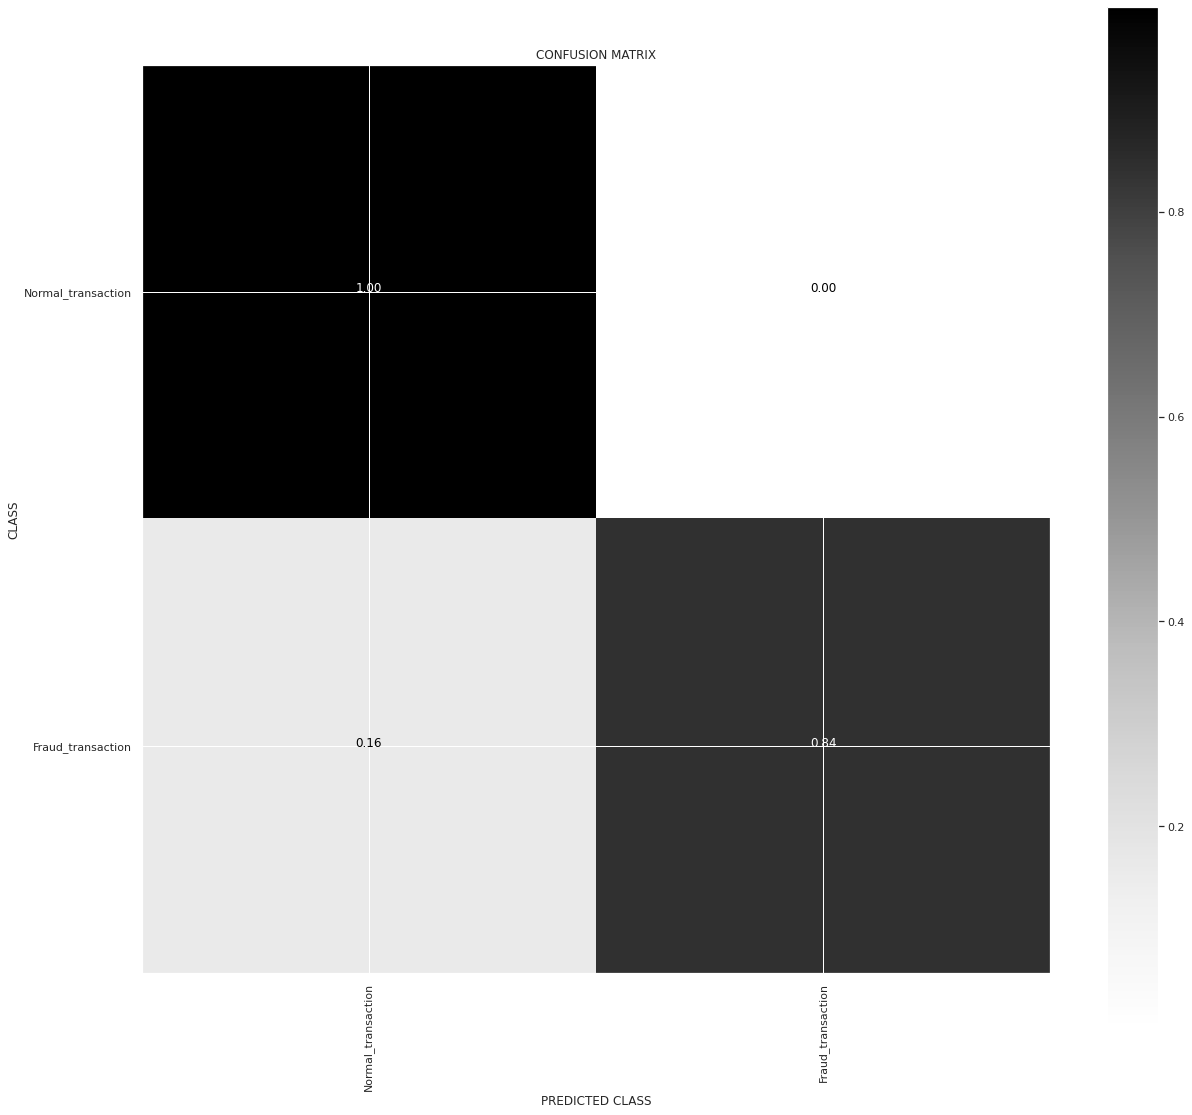

In [28]:
plot_confusion_matrix(random_forest_en, X_test, y_test, class_names=LABELS, file_name='ConfussionMatri-RF', normalize=True)